# Create Models	50	

Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [2]:
import pandas as pd
import numpy as ny
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import plotly.express as px
import os 
import sklearn.model_selection as ms
from sklearn.linear_model import LogisticRegression
import sklearn.linear_model as lm
from sklearn import metrics as mt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score,brier_score_loss, precision_score, recall_score,f1_score)
import time

In [9]:
!pip3 install pickle5
import socket
import pickle5 as pickle

is_rohit=socket.gethostname()=='Rohits-MacBook-Pro.local'
is_blake=socket.gethostname()=='BJH-ML-machine'
is_neddy=(is_rohit+is_blake==0)

if(is_rohit):
    with open('~/Documents/yelp_datasets/df_business_eda.pickle', "rb") as f:
      pick_data = pickle.load(f)
      pick_data.to_pickle('~/Documents/yelp_datasets/df_business_eda_proto4.pickle')
    df_business_eda = pd.read_pickle("~/Documents/yelp_datasets/df_business_eda_proto4.pickle")
    
if(is_blake):
    df_business_eda = pd.read_pickle("df_business_eda.pickle")

In [10]:
df_business_eda.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,city_state,zip3,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,funny_count,review_count,review_word_count
1,2,5.0,False,False,False,True,False,Scottsdale_AZ,852,NaN,NaN,9.0,4,1,2,4,121.000000
3,0,2.5,False,True,False,False,True,North Las Vegas_NV,890,4.0,NaN,3.0,1,0,0,3,26.666667


In [11]:
categorical_cols=df_business_eda.select_dtypes(include=['object']).columns

df_business_hot=df_business_eda

for col in categorical_cols:
    dummies=pd.get_dummies(df_business_hot[col], dummy_na=True, prefix=col)
    df_business_hot=df_business_hot.\
        drop(col,axis=1).\
    merge(
        dummies,
        how='left',
        left_index=True,
        right_index=True
        )
    
df_business_hot=df_business_hot.fillna(False)
df_business_hot.head(2)

,rating_category,stars,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
1,2,5.0,False,False,False,True,False,False,False,9.0,...,0,0,0,0,0,0,0,0,0,0
3,0,2.5,False,True,False,False,True,4.0,False,3.0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_business_hot["above_average"] = ny.where(df_business_hot["stars"] > 3.5, 0, 1)
y=df_business_hot.rating_category
y2 = df_business_hot["above_average"]
X=df_business_hot.drop(["rating_category", "stars","above_average"], axis=1)
#Scale your data
scaler = StandardScaler()
scaler.fit(X) 
X_scaled = pd.DataFrame(scaler.transform(X),columns = X.columns)
X_scaled.head(2)

,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
0,-0.284181,-1.686292,-0.507601,0.489254,-0.580683,-0.800061,-0.255661,-0.150669,-0.273438,-0.252466,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0
1,-0.284181,0.593017,-0.507601,-2.043927,1.722109,3.225868,-0.255661,-0.156851,-0.314588,-0.273815,...,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.003164,-0.043309,0.0


In [14]:
num_cv_iterations = 5
num_instances = len(y)
cv_object = ms.ShuffleSplit(n_splits=num_cv_iterations,
                         random_state=123,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=5, random_state=123, test_size=0.2, train_size=None)


In [15]:
def cv_train(name,model,x,y):
    print(f"====Performing Cross Validation for {name}")
    print(f" Iteration ", end = '')
    iter_num=0
    res=pd.DataFrame()

    for train_indices, test_indices in cv_object.split(x,y):
        t = time.time()
        print(f" {iter_num},", end = '')

        X_train = x.iloc[train_indices]
        y_train = y.iloc[train_indices]

        X_test = x.iloc[test_indices]
        y_test = y.iloc[test_indices]

        model.fit(X_train,y_train)  # train object
        y_hat = model.predict(X_test) # get test set precitions

        conf = mt.confusion_matrix(y_test,y_hat)
        
        row=pd.DataFrame([iter_num],columns=['Iteration'])
        row["accuracy"]=accuracy_score(y_test, y_hat)
        row["precision"]=precision_score(y_test, y_hat, average="macro")
        row["recall"]=recall_score(y_test, y_hat, average="macro")
        row["f1"]=f1_score(y_test, y_hat, average="macro")
        row["average_seconds"]= ny.round(time.time() - t)

        res=res.append(row)
        iter_num+=1
    
    #Summarize CV Results 
    summary=res.drop("Iteration",axis=1).agg("mean").to_frame().T
    summary.insert(0,"model",model)
    summary.insert(0,"name",name)
    print("  Cross-validation complete")

    return(summary)

# Compare Competing Models

In [16]:
#LogisticRegression
log_newton_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='newton-cg' )
log_lbfgs_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='lbfgs' )
log_liblinear_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' )
log_sag_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='sag' )
log_saga_model = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='saga')
#SGDClassifier
log_sgd_model = lm.SGDClassifier(n_jobs=-1, loss="log")
svm_sgd_model = lm.SGDClassifier(n_jobs=-1, loss="hinge")

# Model Advantages	10

Discuss the advantages of each model for each classification task.Does one type of model offer superior performance over another in terms of prediction accuracy? In our quest to find the best parameters that will give us the least error (minimize the cost function) in predicting the output, we fitted each solver in Scikit-learn in the logistic regression.In addition, we also used SGD classifier so it can implement the stochastic gradient descent learning routine that will support different loss functions and penalties for our classification.  For SVM, we did use the SGD classifier to train the model in a reasonable timeframe.  Both the Logistic regression and SVM with a linear kernel yielded very similar performance in terms of prediction accuracy. Even after tuning the parameters to find the optimum value for each parameter so that our model's accuracy can improve, they both had similar performance.  

In terms of training time or efficiency? The default Scikit-learn solver lbfgs had the least trainig time compared to other logistic regression models fitted for other resolvers. This is to be expected as the lbfgs algorithm uses the least memory by employing a method where iterations start at a random optimal value(x) and proceeds to refine that optimal value with a series of better estimates x1, x2. The logisticRegression fitted for SGDClassifier did did not have faster training time compared to the LR model fitted for lbfgs. Comparing the LogisticRegression with default solver with the SVM model, the LogisticRegression still performed efficiently in terms of training time.  


In [17]:
#supressing warnings, many of the logistic models complain during fitting
import warnings
warnings.filterwarnings('ignore')

#Run CV on all models and combine results into dataframe
cv_results=cv_train("log_newton",log_newton_model, X_scaled, y2).\
    append(cv_train("log_lbfgs",log_lbfgs_model, X_scaled, y2)).\
    append(cv_train("log_liblinear",log_liblinear_model, X_scaled, y2)).\
    append(cv_train("log_sag",log_sag_model, X_scaled, y2)).\
    append(cv_train("log_saga",log_saga_model, X_scaled, y2)).\
    append(cv_train("log_sgd",log_sgd_model, X_scaled, y2)).\
    append(cv_train("svm_sgd",svm_sgd_model, X_scaled, y2)).\
    sort_values("f1", ascending=False)

cv_results

====Performing Cross Validation for log_newton
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_lbfgs
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_liblinear
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sag
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_saga
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for log_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete
====Performing Cross Validation for svm_sgd
 Iteration  0, 1, 2, 3, 4,  Cross-validation complete


,name,model,accuracy,precision,recall,f1,average_seconds
0,log_lbfgs,LogisticRegression(),0.689829,0.690756,0.688683,0.688497,2.0
0,log_newton,LogisticRegression(solver='newton-cg'),0.689789,0.690720,0.688641,0.688454,8.2
0,log_liblinear,LogisticRegression(solver='liblinear'),0.689779,0.690707,0.688632,0.688446,15.4
0,log_sgd,"SGDClassifier(loss='log', n_jobs=-1)",0.682200,0.682645,0.681259,0.681161,4.4
0,svm_sgd,SGDClassifier(n_jobs=-1),0.681980,0.684253,0.680370,0.679654,5.0
0,log_sag,LogisticRegression(solver='sag'),0.672480,0.673387,0.671261,0.670937,19.0
0,log_saga,LogisticRegression(solver='saga'),0.665572,0.666413,0.664340,0.663977,19.4


In [18]:
#WINNER-Train final logistic regression model on all scaled data
log_lbfgs_model_final = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='lbfgs',max_iter=15000)
log_lbfgs_model_final.fit(X_scaled,y2)

#Train final SVM model on all scaled data

svm_sgd_model_final = lm.SGDClassifier(n_jobs=-1, loss="hinge")
svm_sgd_model_final.fit(X_scaled,y2)

SGDClassifier(n_jobs=-1)

# Interpret Feature Importance	30

Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?

The objective is to predict that in a given business category, the number of stars the customer provides as part of feedback is determined by multiple factors such as the business location and whether or not the business does provide parking. One of our response variables is customer category rating (in high, low, medium to indicate customers rating of the business). We expect our model to tell the customer the type of rating (high, low, medium) they should expect if there business has certain factors.  

Our analysis shows that the most important feature in our dataset is the cool_count feature. Importance is determined by the qualitative comparison between pairs of predictors of the variables, we think some variables are more important than others because they contribute more to the prediction of the response variable in all possible combinations of predictors. In our context/dataset, this means that count_cool or the number of potential customers who thought that the review was cool, is the top contributer toward determining the customer category & star rating. We also have to take into consideration that precision (how accurate our model is in making a prediction) is only 69% while accuracy is 68%. These insights tell us that we need to tune our parameters to increase our accuracy as we continue to work with this dataset by perhaps removing the less important features. 
  

In [19]:
def get_importance(model):
    feature_importance = abs(model.coef_[0])
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    res=dict(zip(np.array(X.columns)[sorted_idx],feature_importance[sorted_idx]))
    res=dict(sorted(res.items(), key=lambda item: item[1], reverse=True))
    return(res)

def plot_importance(importance_dict, top_n=20):
    importance_dict=dict(sorted(importance_dict.items(), key=lambda item: item[1], reverse=True))
    
    names=list(importance_dict.keys())[0:top_n]
    values=list(importance_dict.values())[0:top_n]
    
    pos = np.arange(len(names)) + .5
    featfig = plt.figure(figsize=(10, top_n/2))
    featax = featfig.add_subplot(1, 1, 1)
    featax.barh(pos, values, align='center')
    featax.set_yticks(pos)
    featax.set_yticklabels(names, fontsize=12)
    featax.set_xlabel('Relative Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

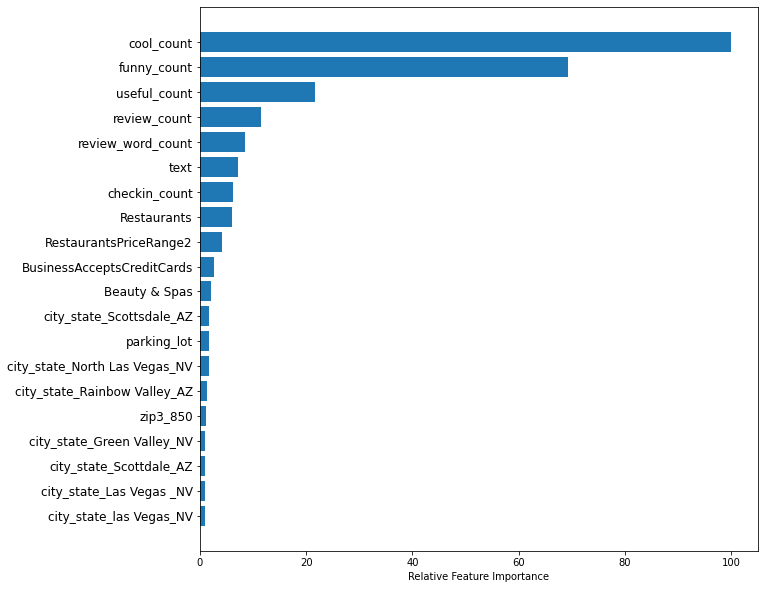

In [20]:
logistic_importance=get_importance(log_lbfgs_model_final)
plot_importance(logistic_importance,top_n=20)

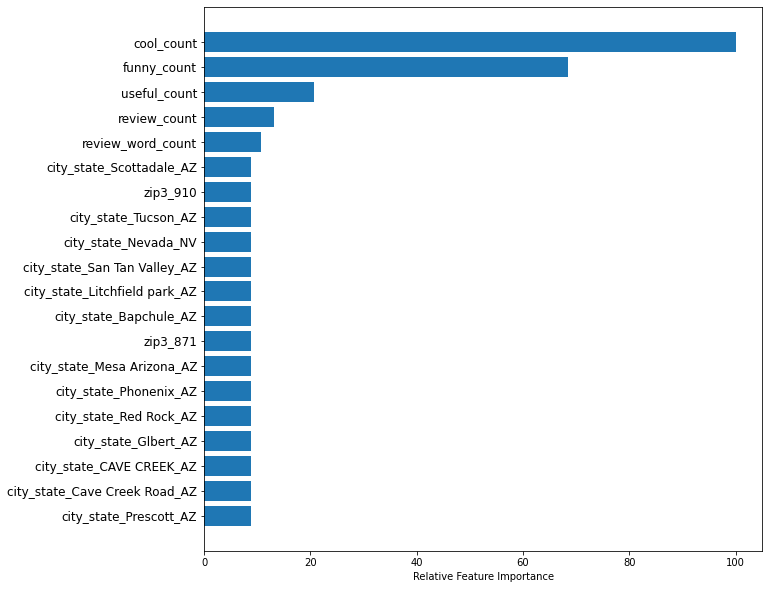

In [21]:
svm_importance=get_importance(svm_sgd_model_final)
plot_importance(svm_importance,top_n=20)

# Interpret Support Vectors	10

Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.

We subsampled our data to train the SVC model and our analysis shows that cool_count is the most important feature in our model. Given that SVC penalizes the algorithm each time there's a misclassfication, this output tells us that cool_count has the highest size of co-efficient when compared to other predictors and we should get rid of the less important features with less variance from the model. In addition, the precision for SVC is only 69% while accuracy is only 68% and maybe removing the less importang variables may increase these values. 

In [24]:
df_business_subset = df_business_hot.sample(frac=0.2,replace=True)

ys=df_business_subset.rating_category
ys2 = df_business_subset["above_average"]
Xs=df_business_subset.drop(["rating_category", "stars","above_average"], axis=1)
#Scale your data

scaler.fit(Xs) 
Xs_scaled = pd.DataFrame(scaler.transform(Xs),columns = Xs.columns)
Xs_scaled.head(2)

,Beauty & Spas,BusinessAcceptsCreditCards,Restaurants,is_open,parking_lot,RestaurantsPriceRange2,text,checkin_count,useful_count,cool_count,...,zip3_928,zip3_930,zip3_940,zip3_952,zip3_953,zip3_959,zip3_967,zip3_981,zip3_nan,zip3_nan
0,-0.283999,0.592747,-0.502236,0.481277,-0.574479,-0.792829,-0.196898,-0.237345,0.248092,-0.056057,...,0.0,-0.007075,0.0,0.0,-0.007075,0.0,0.0,0.0,-0.046445,0.0
1,-0.283999,-1.687059,-0.502236,0.481277,-0.574479,-0.792829,-0.294999,-0.205649,-0.355333,-0.298163,...,0.0,-0.007075,0.0,0.0,-0.007075,0.0,0.0,0.0,-0.046445,0.0


In [25]:
from sklearn.svm import SVC

In [28]:
for train_indices, test_indices in cv_object.split(Xs_scaled,ys2):

        X_train = Xs_scaled.iloc[train_indices]
        y_train = ys2.iloc[train_indices]

        X_test = Xs_scaled.iloc[test_indices]
        y_test = ys2.iloc[test_indices]

In [38]:
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='scale') # get object
svm_clf.fit(X_train, y_train)  # train object

y_hat = svm_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)


In [33]:
precision=precision_score(y_test, y_hat)
recall=recall_score(y_test, y_hat)
f1=f1_score(y_test, y_hat)
print(f'accuracy:{acc}, precision:{precision}, recall:{recall}, f1:{f1}')
print(conf)

accuracy:0.6816816816816816, precision:0.6923529411764706, recall:0.6111111111111112, f1:0.649200220628792
[[1547  523]
 [ 749 1177]]


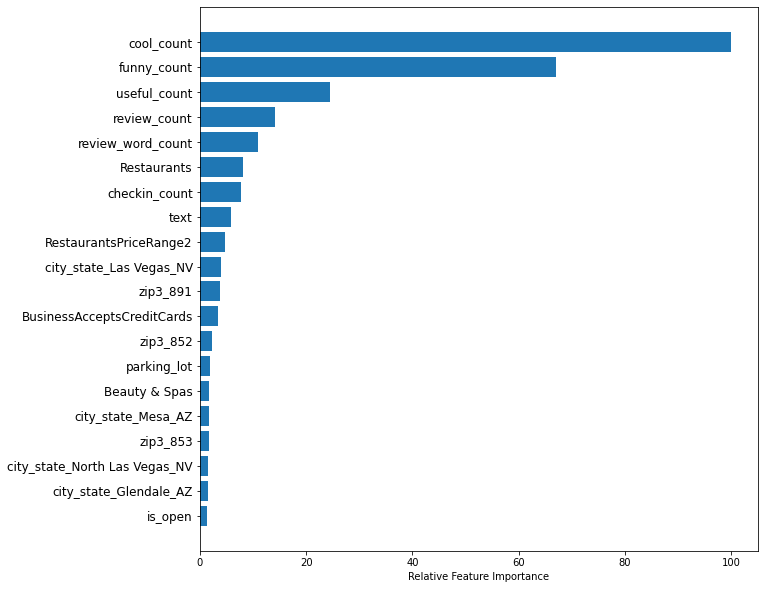

In [39]:
svc_importance=get_importance(svm_clf)
plot_importance(svc_importance,top_n=20)